[Variational Bayesian methods](https://en.wikipedia.org/wiki/Variational_Bayesian_methods) are a great way to get around the computational challenges usually associated with Bayesian inference. Because the posterior distributions are often difficult to evaluate, variational methods approximate the true posterior by a parametric distribution with known functional form. The inference algorithm is thus reduced to an optimisation problem whose objective is to tune the parameters of the approximate distribution such that the posterior is approximated well. Using the popular [mean-field](https://en.wikipedia.org/wiki/Variational_Bayesian_methods#In_practice) approximation, guarantees that the EM-like updates increase the evidence lower bound (ELBO) with every iteration. However, the values of the variational parameters can oscillate if they are strongly coupled by the posterior distribution. The resulting slow convergence is often not obvious from monitoring the ELBO. In this post, we illustrate the problem using a simple linear regression model, and consider alternatives that can help to fit Bayesian models using variational approximations.

The standard linear regression problem is defined by

$$
y_i = \sum_{j=1}^p X_{ij} \theta_j + \epsilon_i,
$$

where $y$ is a length-$n$ vector of values we want to predict, $X$ is the $n\times p$ design of $p$ covariates for each observation, $\theta$ are the unknown regression coefficients we need to determine, and $\epsilon_i$ is Gaussian noise. We assume that the noise precision $\tau$, i.e. the inverse variance, is known. Let's generate some data.

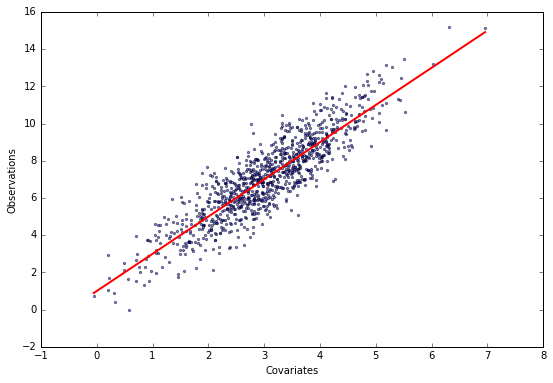

In [26]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (9, 6)


# Define the number of observations and the number of features
n, p = 1000, 2
# Define the noise precision $\tau$
noise_precision = 1
# Use a seed for reproducibility
np.random.seed(1)

# Generate a design matrix
X = np.hstack([np.ones((n, 1)), np.random.normal(3, 1, (n, p - 1))])
# Define regression coefficients
theta = np.asarray([1, 2])
# Generate observations
y = np.dot(X, theta) + np.random.normal(0, 1, n) / np.sqrt(noise_precision)

# Plot the synthetic data
plt.scatter(X[:, 1], y, marker='.', alpha=.5)

# Plot the underlying relationship
x = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]))
plt.plot(x, theta[0] + theta[1] * x, color='r', lw=2)
plt.ylabel('Observations')
plt.xlabel('Covariates')
pass

## Mean-field variational inference
The log-likelihood is

$$\begin{align*}
\log P(y\vert X\theta\tau)&= -\frac{n\log\tau}{2} - \frac{\tau}{2}\sum_{i=1}^n\left(y_i-\sum_{j=1}^pX_{ij}\theta_j\right)^2\\
&= -\frac{n\log\tau}{2} - \frac{\tau}{2}\sum_{i=1}^n\left(y_i^2-2y_i\sum_{j=1}^pX_{ij}\theta_j +\sum_{j=k=1}^p X_{ij}\theta_jX_{ik}\theta_k\right).
\end{align*}$$

We assume flat priors for the regression parameters $\theta$ such that the log-joint distribution $\log P(y\theta\vert X\tau)$ is equal to the log-likelihood up to an additive constant. 

Using the mean-field approach, we approximate the true log-posterior $\log P(\theta\vert Xy\tau)$ by a sum of independent terms for each regression coefficient $\log Q(\theta)=\sum_{j=1}^p \log Q_j\left(\theta_j\right)$. The optimal factor for $\theta_j$ is

$$
\log Q^*_j\left(\theta_j\right)\doteq\left\langle\log P(y\theta\vert X\tau)\right\rangle_{k\neq j},
$$

where the subscript $k\neq j$ indicates that the expectation is taken with respect to the posterior approximations $Q_k$ of all regression coefficients $k\neq j$, and $\doteq$ denotes equality up to an additive constant. Substituting the log-likelihood gives

$$
\log Q^*_j\left(\theta_j\right)\doteq -\frac \tau 2 \sum_{i=1}^n\left(X_{ij}^2\theta_j^2 - 2 \theta_j X_{ij} \left[y_i-\sum_{k\neq j}X_{ik}\left\langle\theta_k\right\rangle\right]\right)
$$

such that the optimal factor $Q^*_j$ is a normal distribution with precision $\lambda_j=\tau\sum_{i=1}^nX_{ij}^2$ and mean $\mu_j=\lambda^{-1}_j\sum_{i=1}^n X_{ij} \left[y_i-\sum_{k\neq j}X_{ik}\left\langle\theta_k\right\rangle\right]$. The posterior mean $\mu_j$ agrees with intuition: the best parameter estimate must account for the observations after we have controlled for the effect of all the other covariates. Let's implement the mean-field inference and plot a trace of the parameter values.


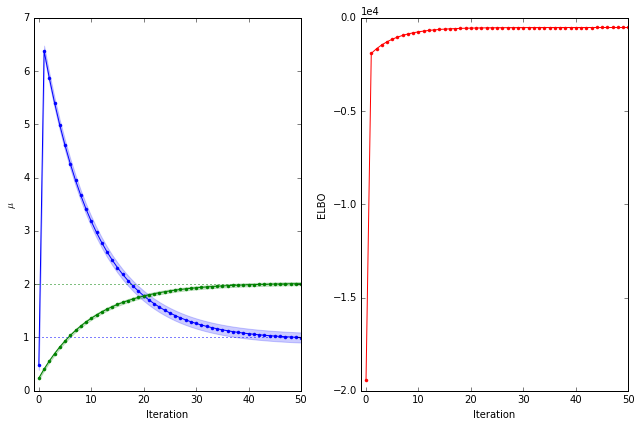

In [27]:
def fit_mean_field(X, y, steps, mu=None):
    """
    Fit a simple linear model using a variational mean-field approximation.
    """
    # First evaluate the precisions because they do not need to be updated
    lmbda = noise_precision * np.sum(X ** 2, axis=0)

    # Initialise the parameter values to some random values unless they are provided
    if mu is None:
        mu = np.random.normal(0, 1, p)
    mu_trace = [np.copy(mu)]

    # Iteratively apply updates
    for step in range(steps):
        # Iterate over all parameters
        for j in range(p):
            # Compute the new posterior mean estimate
            mu[j] = np.dot(X[:, j], y - np.dot(X, mu) + X[:, j] * mu[j]) / lmbda[j]
            # Store the current estimate
            mu_trace.append(np.copy(mu))
        
    return np.asarray(mu_trace)


def plot_trace(trace, reference=None, X=None, sigma=3, ax=None):
    """
    Plot a trace of parameter values.
    """
    ax = ax or plt.gca()
    
    # Iterate over all parameters
    step = trace.shape[1]
    for j, x in enumerate(np.transpose(trace[::step])):
        # Plot the line
        line, = ax.plot(x, marker='.')
        # Plot the reference value
        if reference is not None:
            ax.axhline(reference[j], color=line.get_color(), ls=':')
        # Plot the uncertainty
        if X is not None:
            err = np.sum(X[:, j] ** 2) ** -0.5
            ax.fill_between(np.arange(len(x)), x - sigma * err, 
                            x + sigma * err, color=line.get_color(), alpha=.2)
        
            

def evaluate_elbo(mu, X, y):
    """
    Compute the evidence lower bound (discussed below).
    """
    lmbda = noise_precision * np.sum(X ** 2, axis=0)
    predictor = np.dot(X, mu)
    
    return - 0.5 * len(X) * np.log(noise_precision) - 0.5 * noise_precision * (
        np.dot(y, y) - 2 * np.dot(y, predictor) + np.dot(predictor, predictor) + np.sum(1.0 / lmbda))
            
            
# Generate a trace of parameter values
mu_trace = fit_mean_field(X, y, 50)

# Plot the trace
fig, (ax1, ax2) = plt.subplots(1, 2, True)
plot_trace(mu_trace, theta, X, ax=ax1)
ax1.set_xlabel('Iteration')
ax1.set_ylabel(r'$\mu$')

# Plot the ELBO
elbos = np.asarray([evaluate_elbo(mu, X, y) for mu in mu_trace[::p]])
ax2.plot(elbos, color='r', marker='.')
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.set_xlim(left=-1)
ax2.set_ylabel('ELBO')
ax2.set_xlabel('Iteration')

fig.tight_layout()

What's happening? The initial parameter values are not far from the optimal values but they shoot off to strange values before returning to the true parameter values. This isn't a problem for our small example but can be problematic for larger models. The reason behind this strange behaviour becomes apparent when we consider the trajectory of the parameters $\mu$. Let's have a look.

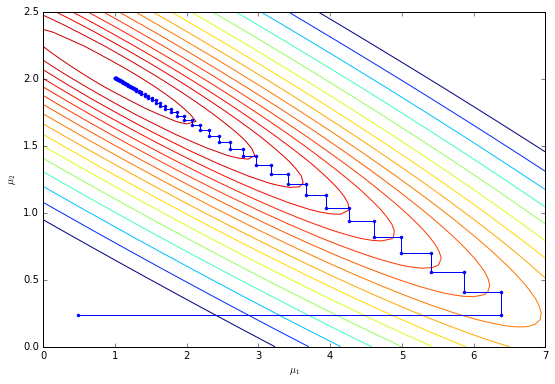

In [28]:
ax = plt.subplot(111)
# Plot the trajectory
ax.plot(mu_trace[:, 0], mu_trace[:, 1], marker='.')
ax.set_xlabel(r'$\mu_1$')
ax.set_ylabel(r'$\mu_2$')

# Plot the energy landscape
mu1 = np.linspace(*ax.get_xlim())
mu2 = np.linspace(*ax.get_ylim())

landscape = np.reshape([evaluate_elbo((_mu1, _mu2), X, y) for _mu1 in mu1 for _mu2 in mu2], (50, 50))
ax.contour(mu1, mu2, landscape.T, levels=-np.logspace(4, 0, 50))
pass

The algorithm updates each parameter in turn similar to [coordinate descent](https://en.wikipedia.org/wiki/Coordinate_descent). Because it updates $\mu_1$ first, it takes a step to a location far from the optimal parameter value for $\mu_2$. The algorithm subsequently walks down the ELBO mountain until it reaches the maximum. Let's try this with a larger model with more features.

In [29]:
# Define the number of observations and the number of features
n, p = 1000, 10
# Define the noise precision $\tau$
noise_precision = 1

# Generate a design matrix
X = np.random.normal(3, 1, (n, p))
# Define regression coefficients
theta = np.random.normal(1, 1, p)
# Generate observations
y = np.dot(X, theta) + np.random.normal(0, 1, n) / np.sqrt(noise_precision)

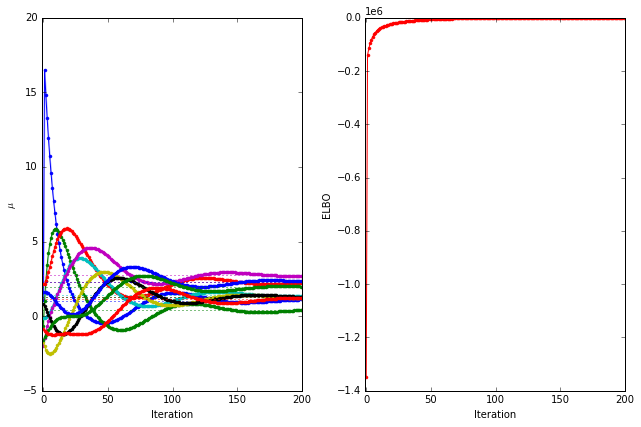

In [32]:
# Generate a trace of parameter values
mu_trace = fit_mean_field(X, y, 200)

# Plot the trace
fig, (ax1, ax2) = plt.subplots(1, 2, True)
plot_trace(mu_trace, theta, X, ax=ax1)
ax1.set_xlabel('Iteration')
ax1.set_ylabel(r'$\mu$')

# Plot the ELBO
elbos = np.asarray([evaluate_elbo(mu, X, y) for mu in mu_trace[::p]])
ax2.plot(elbos, color='r', marker='.')
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.set_xlim(left=-1)
ax2.set_ylabel('ELBO')
ax2.set_xlabel('Iteration')

fig.tight_layout()

The parameter values oscillate before approaching the parameter region that maximises the ELBO. In models with thousands of parameters, these oscillations can persist for a long time. Can we do better?

## Variational inference using machine learning frameworks

Machine learning frameworks such as [theano](http://deeplearning.net/software/theano/) and [tensorflow](https://www.tensorflow.org/) are designed to let you define a function symbolically and find its extrema using gradient-based optimisation. The frameworks provide efficient methods for calculating gradients by using the same symbolic call graph that defined the objective function.

Our objective is to maximise the ELBO, which is given by

$$
\mathcal{L}=\left\langle\log P(y\theta|X\tau)\right\rangle + H\left[Q\right],
$$

where $H[Q]$ is the entropy of the approximate distribution. We know that the factors $Q_j$ are normal distributions with mean $\mu_j$ and precision $\lambda_j$ such that 

$$\begin{align*}
\mathcal{L}\left(\mu,\lambda\right)&=-\frac{n\log\tau}{2} - \frac{\tau}{2}\sum_{i=1}^n\left(y_i^2-2y_i\sum_{j=1}^pX_{ij}\mu_j +\sum_{j=k=1}^p X_{ij}\mu_jX_{ik}\mu_k + \sum_{j=k}^p X_{ij}^2 \lambda_j^{-1}\right) \\
&\quad-\frac 12\sum_{j=1}^p\log\lambda_j+ \frac{p}{2}\log\left(2\pi\right).
\end{align*}$$

Setting the derivative of the ELBO with respect to $\lambda$ to zero, we find

$$\begin{align*}
\frac{\partial\mathcal{L}\left(\mu,\lambda\right)}{\partial\lambda_j}&=\frac\tau 2\sum_{i=1}^nX_{ij}^2\lambda^{-2}_j - \frac{\lambda_j^{-1}}{2}=0\\
\therefore \lambda_j&=\tau\sum_{i=1}^n X_{ij}^2,
\end{align*}$$

which is the same expression we obtained using the mean-field update equations. The expressions for $\mu$ are more complicated and we will make use of theano to do the heavy lifting for us. We will first define a call graph that evaluates the ELBO and then use gradient ascent to find the maximum.

In [38]:
import theano
import theano.tensor as T

# Define symbolic variables
t_X = T.matrix('X')
t_theta = theano.shared(np.random.normal(0, 1, p), 'theta')
t_y = T.vector('y')

# Compute the values for lambda explicitly
t_lmbda = T.sum(t_X ** 2, axis=0)

# Evaluate the predictor
t_predictor = T.dot(t_X, t_theta)

# Evaluate the ELBO
t_elbo = - n * np.log(noise_precision) / 2 - noise_precision * (
    T.dot(t_y, t_y) - 2 * T.dot(t_y, t_predictor) + 
    T.dot(t_predictor, t_predictor) + p) / 2 \
    - T.sum(t_lmbda) / 2 + p * np.log(2 * np.pi) / 2
  
# Evaluate the gradient
t_grad = theano.grad(t_elbo, t_theta)
    
train = theano.function(inputs=[t_X, t_y], outputs=[t_theta, t_elbo],
                        updates = [[t_theta, t_theta + 0.1 * t_grad]])

In [39]:
mu_trace, elbos = np.transpose([train(X, y) for _ in range(50)])

In [40]:
mu_trace

array([ array([ 0.43682543,  0.19851135, -0.51074653, -1.10713368, -0.59611197,
       -0.62574483,  0.8129007 , -1.78076227, -0.04264141, -1.51817998]),
       array([ 18593.35986552,  18906.25722343,  18938.89599926,  18396.25516495,
        19006.08653931,  18505.8302625 ,  18687.30560945,  18800.00195465,
        18745.00155901,  18945.17880069]),
       array([ -1.71373536e+08,  -1.74605992e+08,  -1.72415774e+08,
        -1.67834537e+08,  -1.72627198e+08,  -1.69478309e+08,
        -1.72513151e+08,  -1.70086781e+08,  -1.71572446e+08,
        -1.72956429e+08]),
       array([  1.56802217e+12,   1.59762796e+12,   1.57732395e+12,
         1.53546928e+12,   1.57923298e+12,   1.55057871e+12,
         1.57848819e+12,   1.55592577e+12,   1.56972264e+12,
         1.58235461e+12]),
       array([ -1.43458198e+16,  -1.46166856e+16,  -1.44308958e+16,
        -1.40479763e+16,  -1.44483605e+16,  -1.41862199e+16,
        -1.44415782e+16,  -1.42351166e+16,  -1.43613650e+16,
        -1.44769332e+1